# Masking

The idea of this experiment is to superpose a fixed frequency signal (gabor) with a fixed frequency noise and change their constrasts to see how that affects how we see the whole image. The expected outcome is to see the *masking* phenomenon, in which the noise masks the signal and it can't be seen.

## Importing libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

from perceptnet.networks import PerceptNet

## Loading the images

In [2]:
path_tests = '/media/disk/users/paherca/Perceptual_tests'
path_lf = 'gabors_noise_same_freq_low_freq.npy'
path_hf = 'gabors_noise_same_freq_high_freq.npy'

In [3]:
gabor_lf = np.load(os.path.join(path_tests, path_lf))
gabor_hf = np.load(os.path.join(path_tests, path_hf))

gabor_lf.shape, gabor_hf.shape

((256, 256, 3, 8, 5), (256, 256, 3, 8, 5))

These files have (256,256,3) images created with 8 different contrasts for the signal (4th dim), and 5 different contrasts for the noise (5th dim).

To be able to pass the through our model in a more confortable way we could transpose the so that the contrasts act as "batch dims".

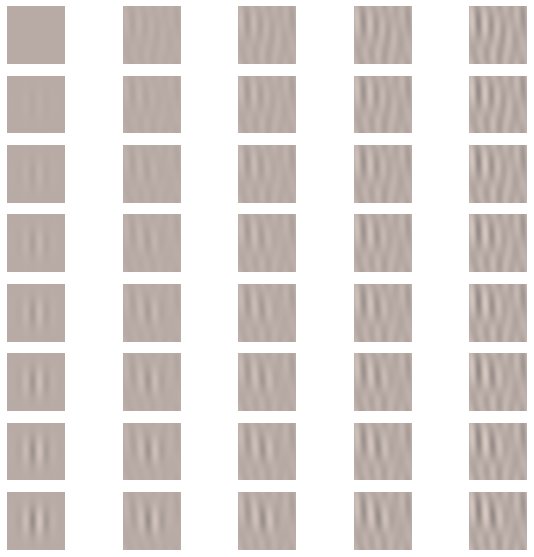

In [4]:
fig, ax = plt.subplots(*gabor_lf.shape[-2:], figsize=(10,10))
for i in range(gabor_lf.shape[-2]):
    for j in range(gabor_lf.shape[-1]):
        ax[i][j].imshow(gabor_lf[:,:,:,i,j])
        ax[i][j].axis('off')
plt.show()

In [5]:
freqs = [2, 4, 8, 16, 32]
contrasts = 0.7*np.linspace(0, 0.15, 8)
contrasts_noises = 0.4*np.array([0, 0.1, 0.2, 0.3, 0.4])

In [6]:
gabor_lf = gabor_lf.transpose(4,3,0,1,2)
gabor_hf = gabor_hf.transpose(4,3,0,1,2)

gabor_lf.shape, gabor_hf.shape

((5, 8, 256, 256, 3), (5, 8, 256, 256, 3))

We can plot the data to make sure everything is correct:

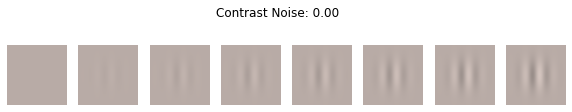

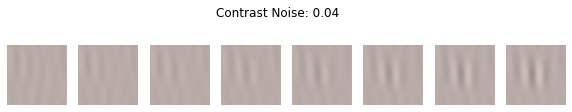

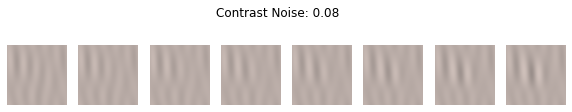

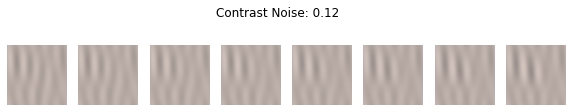

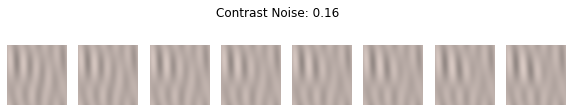

In [7]:
for i in range(len(contrasts_noises)):
    fig, ax = plt.subplots(1, 8, figsize=(10,2))
    for j,img in enumerate(gabor_lf[i]):
        ax[j].imshow(img)
        ax[j].axis('off')
    plt.suptitle(f'Contrast Noise: {contrasts_noises[i]:.2f}')
    plt.show()

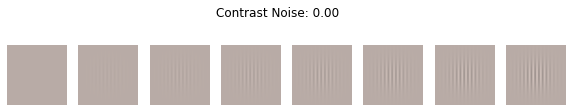

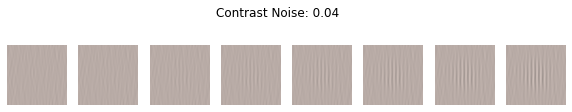

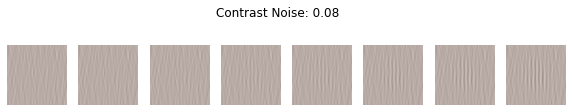

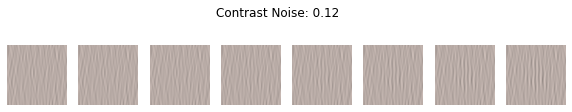

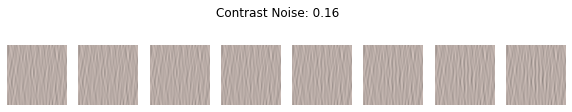

In [8]:
for i in range(len(contrasts_noises)):
    fig, ax = plt.subplots(1, 8, figsize=(10,2))
    for j,img in enumerate(gabor_hf[i]):
        ax[j].imshow(img)
        ax[j].axis('off')
    plt.suptitle(f'Contrast Noise: {contrasts_noises[i]:.2f}')
    plt.show()

## Passing the colors through the network

In [9]:
weights_path = get_file(fname='perceptnet_rgb.h5',
                        origin='https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')

In [10]:
model = PerceptNet(kernel_initializer='ones', gdn_kernel_size=1, learnable_undersampling=False)
model.build(input_shape=(None, 384, 512, 3))
model.load_weights(weights_path)

2022-05-08 21:10:06.901871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


We can do the processing on the fly to save memory:

> The output of each image must be compared to the output produced by the image where the signal's contrast is 0, so we will have to always compare to the first element in each batch.

In [11]:
def get_readouts(model, imgs):
    ## Pass the through the model
    outputs = model.predict(imgs)

    ## Get the readouts as the distance to the lowest freq image
    readouts = (outputs-outputs[0])**2
    readouts = np.sqrt(np.sum(readouts.reshape(imgs.shape[0],-1), axis=-1))
    
    ## Return readouts
    return readouts

In [18]:
def plot_results(results, color='k'):
    alphas = np.linspace(0.2,1,len(results))
    markers = ['o', '*', '^', 's', '.']
    for i, (c_noise, readouts) in enumerate(results.items()):
        plt.plot(contrasts, readouts, color, alpha=alphas[i], marker=markers[i], label=f'Contrast (Noise) = {c_noise:.2f}')
        plt.xlabel('Contrast (Signal)')
        plt.ylabel('Visibility')

In [13]:
results_lf = {}
for c_noise, batch in zip(contrasts_noises, gabor_lf):
    results_lf[c_noise] = get_readouts(model, batch)

2022-05-08 21:10:08.456803: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-08 21:10:09.293152: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-05-08 21:10:09.793373: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [14]:
results_hf = {}
for c_noise, batch in zip(contrasts_noises, gabor_hf):
    results_hf[c_noise] = get_readouts(model, batch)

Plot the results:

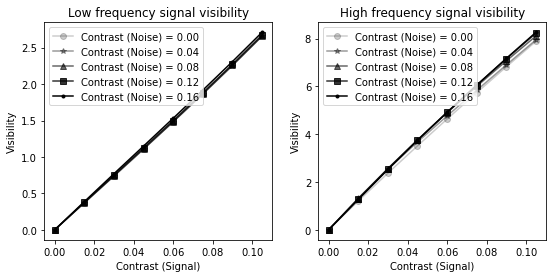

In [19]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.title('Low frequency signal visibility')
plot_results(results_lf)
plt.legend()

plt.subplot(1,2,2)
plt.title('High frequency signal visibility')
plot_results(results_hf)
plt.legend()

plt.show()